In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
TS_SPLIT = 10 # how many splits for timeseries
WINDOW_SIZE = 5 # how many minutes to aggregate as single datapoint
PREDICT_AHEAD1 = 6 # how far time ahead predict 1st model
PREDICT_AHEAD2 = 10 # how far ahead predict 2nd model
EARLY_STOP = 10 # stopping xgboost training if it's not progressing
RESAMPLE_MIN = 1 # original data are in 1-sec intervals, but that's not good for training?

In [33]:
data_folder = Path('../Zadanie 2 Stabilizacja pracy pieca zawiesinowego/OPT/')

In [34]:
types = ['manipulowane', 'zaklocajace', 'zaklocane', 'straty']
types2 = ['man', 'zak', 'zcne', 'stra']
files_by_type = {} 
for t,t2 in zip(types,types2):
    files_by_type[t2]= sorted(list(data_folder.glob('2021-05-*/' + t + '*')))  # TODO: 2021-04-19 seems to not work

In [35]:
def all_types_to_df(files_dict, end=100):
    type_to_df = {}
    for t in types2:
        types_csv = []
        for p in files_dict[t][:end]:
            data_df = pd.read_csv(p)
            data_df.columns = map(lambda x: x.lower(), data_df.columns)
            data_df.columns = [data_df.columns[0]] + [t+'_'+nom for nom in data_df.columns[1:]]
            types_csv.append(data_df)
        type_to_df[t] = types_csv
    return type_to_df

In [36]:
type_df = all_types_to_df(files_by_type)

In [37]:
for t in types2:
    d = type_df[t][0].columns.values
    print(type_df[t][0].columns)
    for i in type_df[t]:
        assert np.all(i.columns.values == d), (i,d)

Index(['czas', 'man_001fcx00285_sppv.pv', 'man_001xxxcalc01.num.pv[3]',
       'man_001scx00274_sppv.pv', 'man_001fcx00241_sppv.pv', 'man_unnamed: 5'],
      dtype='object')
Index(['czas', 'zak_001fyx00206_spsum.pv', 'zak_001fcx00231_sppv.pv',
       'zak_001fcx00251_sppv.pv', 'zak_001fcx00281.pv', 'zak_001fcx00262.pv',
       'zak_001fcx00261.pv', 'zak_001xxxcalc01.num.pv[2]', 'zak_prob_corg',
       'zak_prob_s', 'zak_sita_nadziarno', 'zak_sita_podziarno',
       'zak_poziom_zuzel'],
      dtype='object')
Index(['czas', 'zcne_001ucx00274.pv', 'zcne_001nir0ods0.daca.pv',
       'zcne_temp_zuz', 'zcne_007sxr00555.daca1.pv', 'zcne_unnamed: 5'],
      dtype='object')
Index(['czas', 'stra_001nir0szr0.daca.pv', 'stra_001nir0szrg.daca.pv',
       'stra_001nir0s600.daca.pv', 'stra_001nir0s500.daca.pv',
       'stra_001nir0s300.daca.pv', 'stra_001nir0s100.daca.pv'],
      dtype='object')


In [38]:
type_per_df = { t:pd.concat(type_df[t], ignore_index=True) for t in types2}

In [39]:
from functools import reduce
df_final = reduce(lambda left,right: pd.merge(left,right,on='czas'), type_per_df.values())

In [40]:
del df_final['man_unnamed: 5']
del df_final['zcne_unnamed: 5']

czas

man_001fcx00285_sppv.pv 
man_001xxxcalc01.num.pv[3]
man_001scx00274_sppv.pv
man_001fcx00241_sppv.pv

zak_001fyx00206_spsum.pv
zak_001fcx00231_sppv.pv
zak_001fcx00251_sppv.pv
zak_001fcx00281.pv
zak_001fcx00262.pv
zak_001fcx00261.pv
zak_001xxxcalc01.num.pv[2]
zak_prob_corg
zak_prob_s
zak_sita_nadziarno
zak_sita_podziarno
zak_poziom_zuzel

zcne_001ucx00274.pv
zcne_001nir0ods0.daca.pv
zcne_temp_zuz
zcne_007sxr00555.daca1.pv

stra_001nir0szr0.daca.pv --- to nas interesuje
stra_001nir0szrg.daca.pv
stra_001nir0s600.daca.pv
stra_001nir0s500.daca.pv
stra_001nir0s300.daca.pv
stra_001nir0s100.daca.pv

In [41]:
translate_naming = {
    "man_001fcx00285_sppv.pv":'man_air_flow',
    "man_001xxxcalc01.num.pv[3]":"man_co2",
    "man_001scx00274_sppv.pv":"man_blow",
    "man_001fcx00241_sppv.pv":"man_dust",
    "zak_001fyx00206_spsum.pv":"zak_mixer",
    "zak_001fcx00231_sppv.pv":"zak_fry",
    "zak_001fcx00251_sppv.pv":"zak_slag",
    "zak_001fcx00281.pv":"zak_oxy1",
    "zak_001fcx00262.pv":"zak_oxy2",
    "zak_001fcx00261.pv":"zak_air",
    "zak_001xxxcalc01.num.pv[2]":"zak_sturoxy",
    "zak_prob_corg":"zak_carbon",
    "zak_prob_s":"zak_sulfur",
    "zak_sita_nadziarno":"zak_over_seed",
    "zak_sita_podziarno":"zak_under_seed",
    "zak_poziom_zuzel":"zak_slag_level",
    "zcne_001ucx00274.pv":"zcne_angle",
    "zcne_001nir0ods0.daca.pv":"zcne_loss",
    "zcne_temp_zuz":"zcne_temp",
    "zcne_007sxr00555.daca1.pv":"zcne_shake",
    "stra_001nir0szr0.daca.pv": "stra_sum",
    "stra_001nir0szrg.daca.pv": "stra_1",
    "stra_001nir0s600.daca.pv":"stra_2",
    "stra_001nir0s500.daca.pv":"stra_3",
    "stra_001nir0s300.daca.pv":"stra_4",
    "stra_001nir0s100.daca.pv":"stra_5",
}
new_cols = [translate_naming.get(cname) or cname for cname in df_final.columns]
df_final.columns = new_cols
df_final = df_final.drop(['stra_1','stra_2','stra_3','stra_4','stra_5'], axis=1, errors='ignore')

# Resampling

In [42]:
df_final['czas'] = pd.to_datetime(df_final['czas'])
df_final = df_final.resample(f'{RESAMPLE_MIN}min', on='czas').mean()
df_final['stra_sum'] = df_final['stra_sum'].rolling(RESAMPLE_MIN).mean().shift(-RESAMPLE_MIN)
df_final = df_final[:-RESAMPLE_MIN]

In [43]:
df_final

,man_air_flow,man_co2,man_blow,man_dust,zak_mixer,zak_fry,zak_slag,zak_oxy1,zak_oxy2,zak_air,...,zak_carbon,zak_sulfur,zak_over_seed,zak_under_seed,zak_slag_level,zcne_angle,zcne_loss,zcne_temp,zcne_shake,stra_sum
czas,,,,,,,,,,,,,,,,,,,,,
2021-05-08 00:00:00,2500.000000,81.0,42.000000,26.0,110.0,9.0,2.0,252.191348,30986.818132,9732.196647,...,8.86,10.59,3.48,60.500000,1368.333333,14.090029,10.451766,1306.933333,-0.195909,21.443804
2021-05-08 00:01:00,2500.000000,81.0,42.000000,26.0,110.0,9.0,2.0,250.130182,30972.921550,9688.775000,...,8.86,10.59,3.48,60.500000,1370.000000,13.982789,10.472038,1307.000000,-0.178600,21.615408
2021-05-08 00:02:00,2500.000000,81.0,42.000000,26.0,110.0,9.0,2.0,248.939719,30974.413965,9657.542057,...,8.86,10.59,3.48,60.500000,1370.000000,13.999340,10.447888,1307.000000,-0.153167,21.721678
2021-05-08 00:03:00,2500.000000,81.0,42.000000,26.0,110.0,9.0,2.0,249.002518,30978.373244,9706.428499,...,8.86,10.59,3.48,60.500000,1370.000000,14.010148,10.397752,1307.000000,-0.057469,21.829619
2021-05-08 00:04:00,2500.000000,81.0,42.000000,26.0,110.0,9.0,2.0,249.329449,30976.005143,9736.590446,...,8.86,10.59,3.48,60.500000,1370.000000,14.348505,10.379728,1307.000000,-0.120352,21.851969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 22:44:00,3500.000000,72.0,52.333333,24.0,114.0,9.0,2.0,248.474277,27553.597559,15069.347819,...,8.81,10.18,3.32,59.400001,1180.000000,19.917808,10.118773,1301.000000,0.283731,17.762617
2021-06-06 22:45:00,3395.833333,72.0,50.000000,24.0,114.0,9.0,2.0,249.073620,27484.005990,15043.780584,...,8.81,10.18,3.32,59.400002,1180.000000,22.040710,10.115715,1301.000000,0.611314,17.744945
2021-06-06 22:46:00,3000.000000,72.0,50.000000,24.0,114.0,9.0,2.0,252.753032,27480.763249,15001.757406,...,8.81,10.18,3.32,59.400002,1180.000000,17.075416,10.118410,1301.000000,0.421282,17.708579


In [47]:
!pip install xgboost

     |████████████████████████████████| 166.7MB 13.2MB/s eta 0:00:01


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb

# Naive training using point-in-time, ie. it completly ignores past datapoints and assumes loss can be calculated only from current state

In [49]:
X = df_final.iloc[:,:-1]
y = df_final.iloc[:,-1]

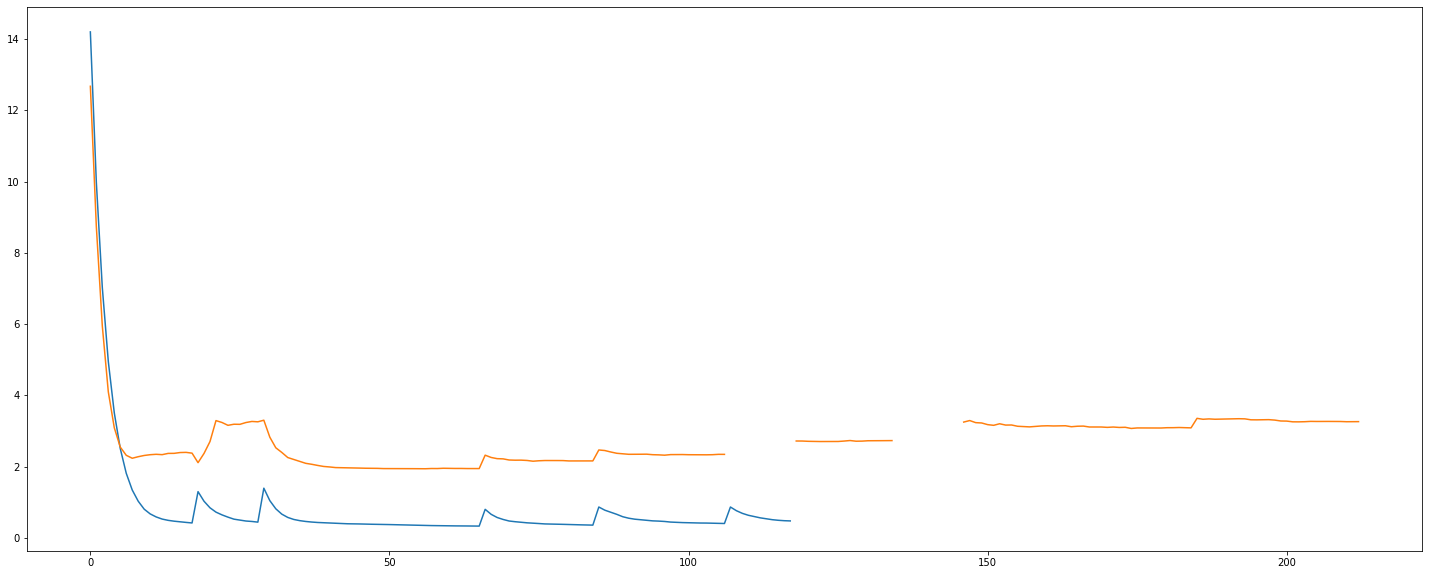

In [50]:
tscv = TimeSeriesSplit(TS_SPLIT)
model1 = xgb.XGBRegressor()
m = None
train_rmse = []
test_rmse = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = model1.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test,  y_test)], verbose=False, xgb_model = m, early_stopping_rounds=10)
    train_rmse += model1.evals_result()['validation_0']['rmse']
    test_rmse += model1.evals_result()['validation_1']['rmse']
    
plt.figure(figsize=(25,10))
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')

<AxesSubplot:xlabel='czas'>

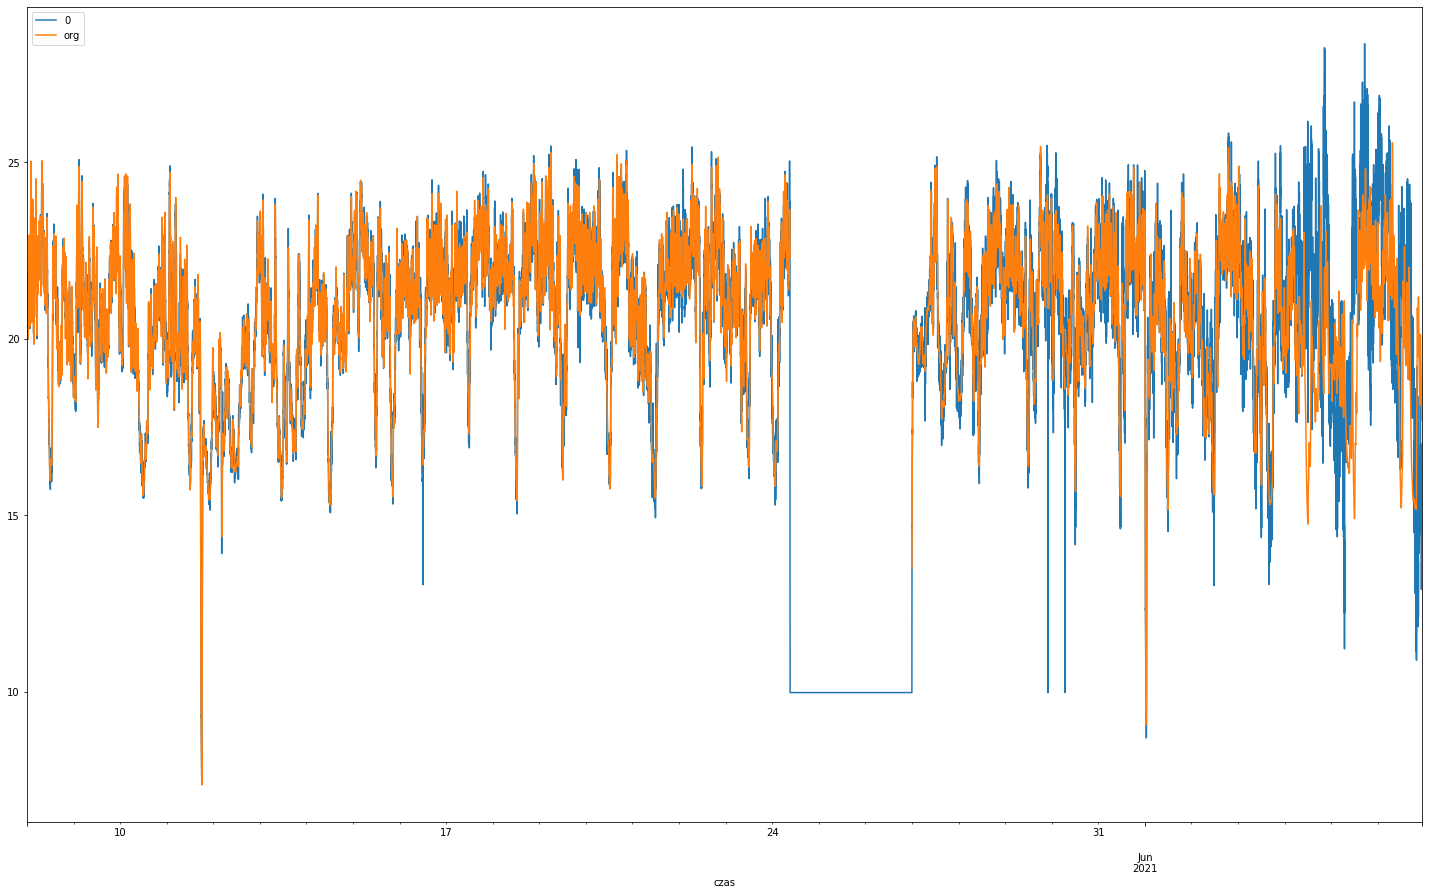

In [51]:
predictions1 = model1.predict(X)
d = pd.DataFrame(predictions1, index=y.index)
d['org'] = y
d.plot(figsize=(25,15))

In [52]:
predictions1 = model1.predict(X_test)
print(mean_squared_error(predictions1, y_test))

10.61808756643377


# Training using aggregated time points (30-min window)

In [53]:
X = df_final.iloc[:,:-1]
X_org = X.copy()
y = df_final.iloc[:,-1]
y_org = y.copy()

for i in range(1, WINDOW_SIZE):
    X_shifted1 = X_org.shift(-i).rename(index=None, columns=lambda c: c + f'_{i}')
    X = X.merge(X_shifted1, left_index=True, right_index=True)
X = X.iloc[:-i,:]
y = y.iloc[i:]

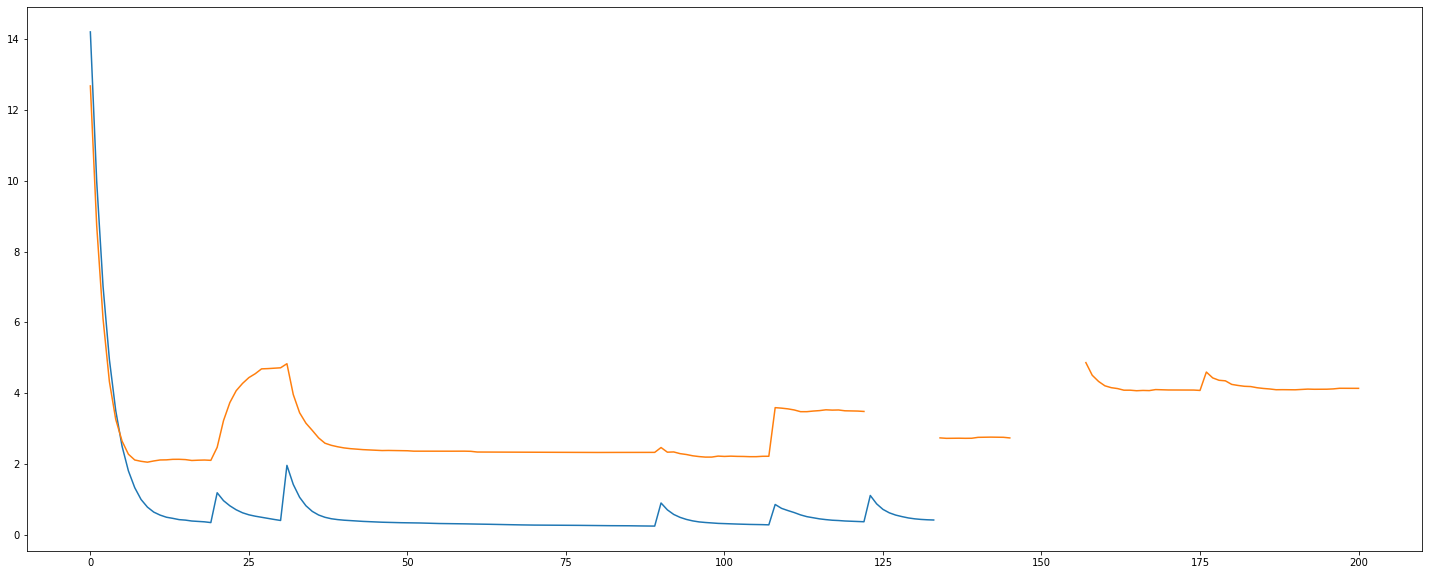

In [54]:
model2 = xgb.XGBRegressor()
tscv = TimeSeriesSplit(TS_SPLIT)
m = None
train_rmse = []
test_rmse = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = model2.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test,  y_test)], verbose=False, xgb_model = m, early_stopping_rounds=EARLY_STOP)
    train_rmse += model2.evals_result()['validation_0']['rmse']
    test_rmse += model2.evals_result()['validation_1']['rmse']

plt.figure(figsize=(25,10))
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')

In [55]:
predictions2 = model2.predict(X_test)
print(mean_squared_error(predictions2, y_test))

16.778964181242063


<AxesSubplot:xlabel='czas'>

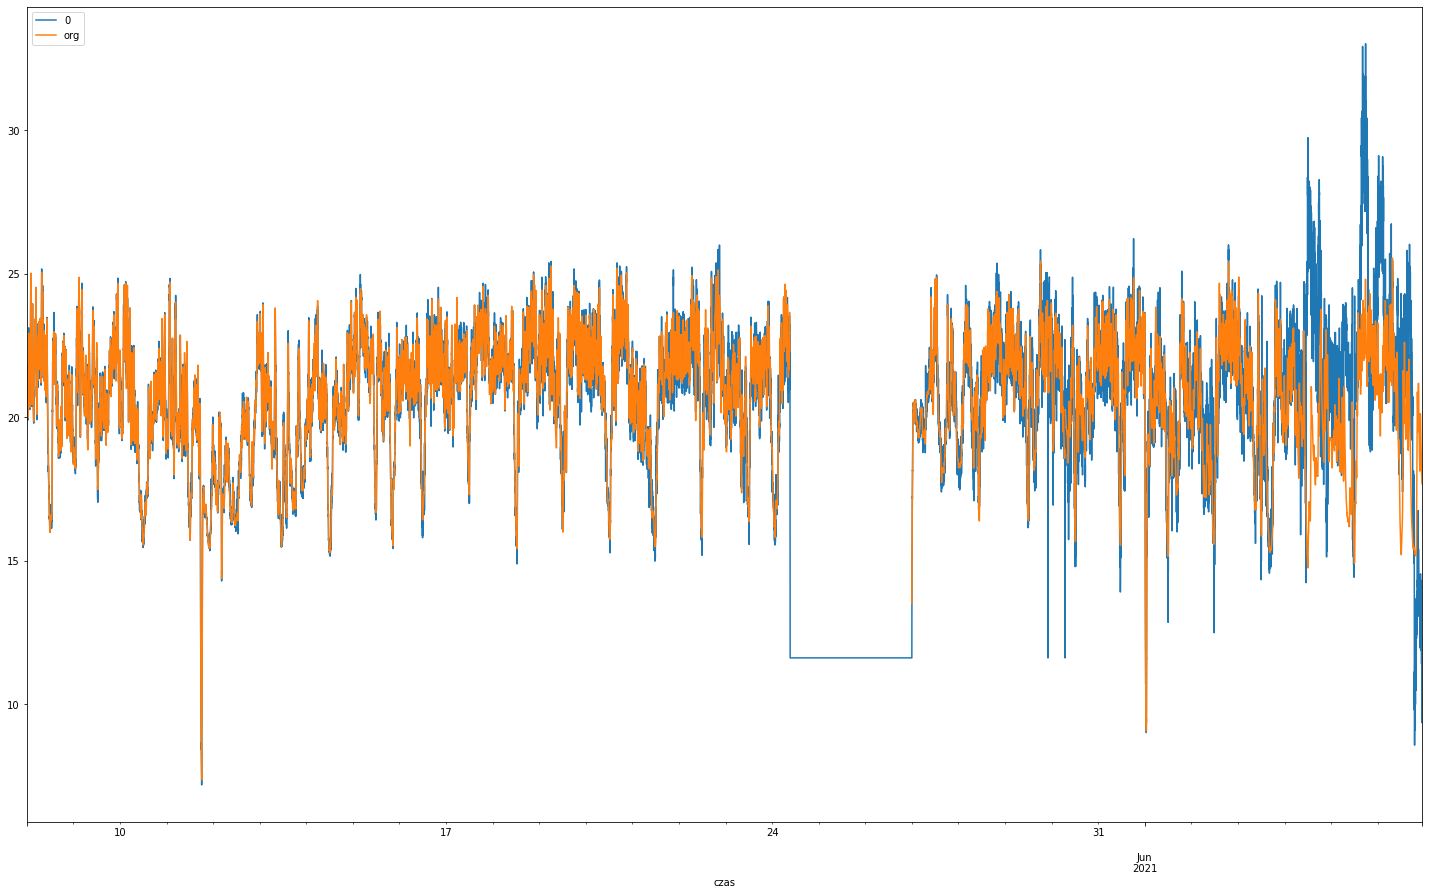

In [56]:
predictions2 = model2.predict(X)
d = pd.DataFrame(predictions2, index=y.index)
d['org'] = y
d.plot(figsize=(25,15))

# Predict using data window of X1 minutes for X2 minutes ahead

In [57]:
X = df_final.iloc[:,:-1]
X_org = X.copy()
y = df_final.iloc[:,-1]
y_org = y.copy()

for i in range(1, WINDOW_SIZE):
    X_shifted1 = X_org.shift(-i).rename(index=None, columns=lambda c: c + f'_{i}')
    X = X.merge(X_shifted1, left_index=True, right_index=True)
X = X.iloc[:-i,:]
y = y.iloc[i:]
    
X = X.iloc[:-PREDICT_AHEAD1,:]
y = y.shift(-PREDICT_AHEAD1).iloc[:-PREDICT_AHEAD1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

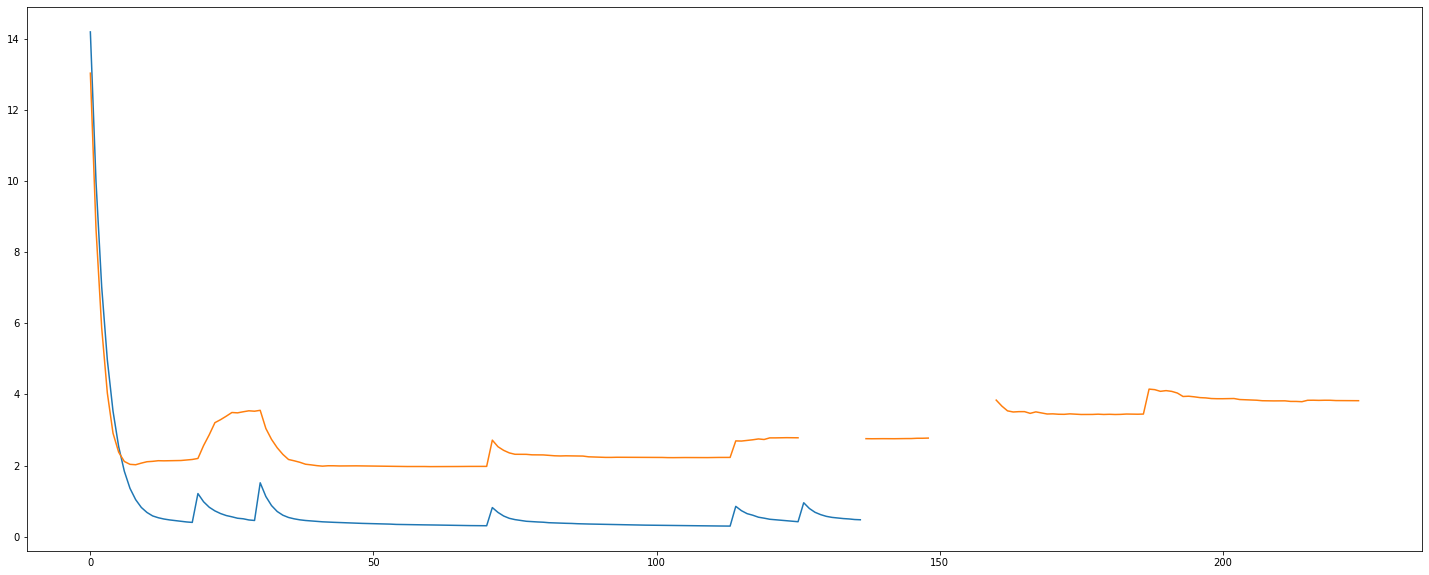

In [58]:
tscv = TimeSeriesSplit(TS_SPLIT)
model3 = xgb.XGBRegressor()
m = None
train_rmse = []
test_rmse = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = model3.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test,  y_test)], verbose=False, xgb_model = m, early_stopping_rounds=EARLY_STOP)
    train_rmse += model3.evals_result()['validation_0']['rmse']
    test_rmse += model3.evals_result()['validation_1']['rmse']

plt.figure(figsize=(25,10))
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')

In [59]:
predictions3 = model3.predict(X_test)
print(mean_squared_error(predictions3, y_test))

14.41647381790263


<AxesSubplot:xlabel='czas'>

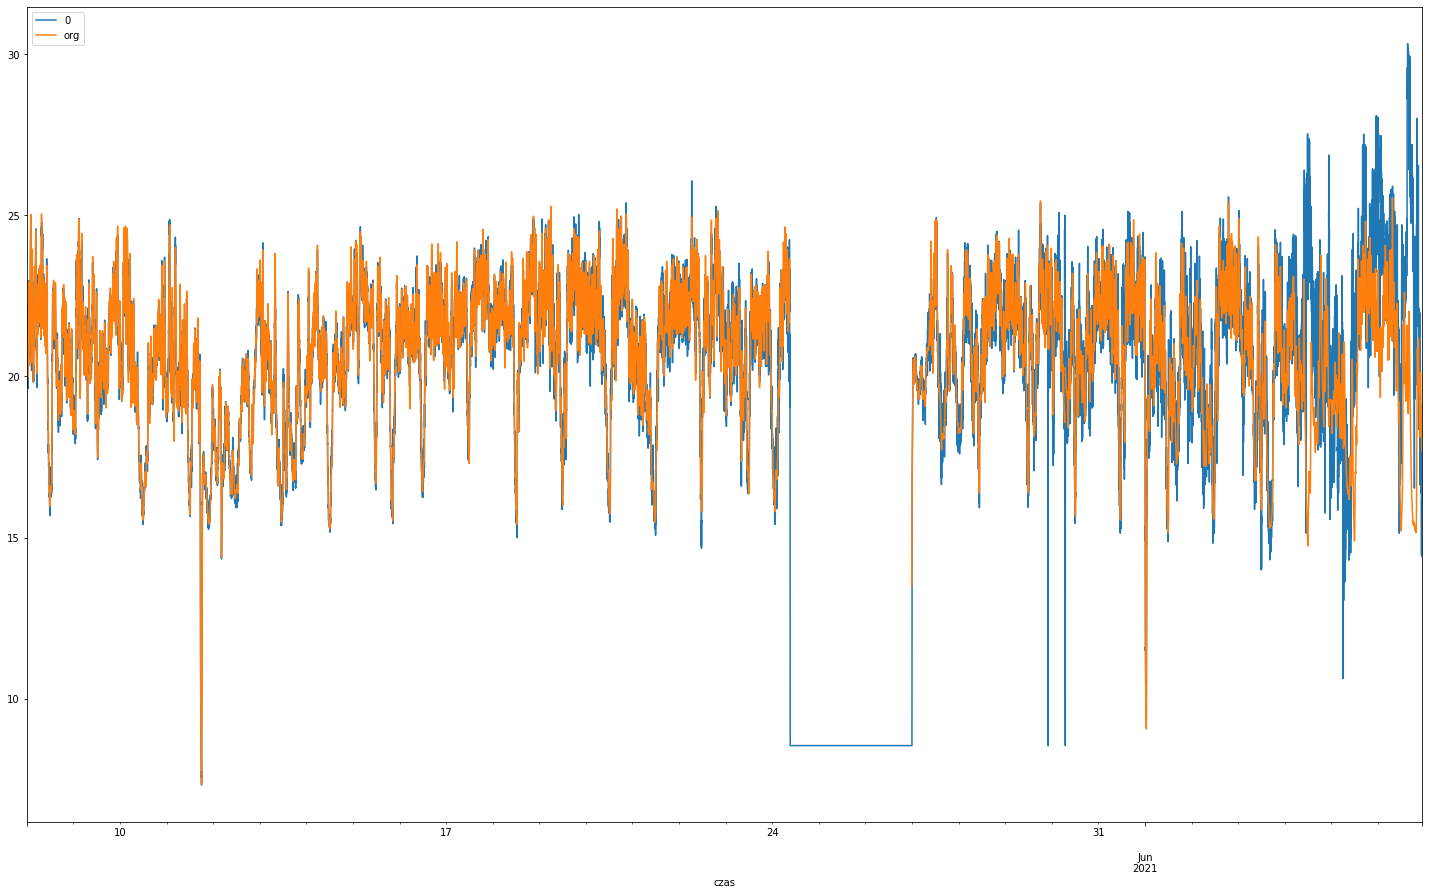

In [60]:
predictions3 = model3.predict(X)
d = pd.DataFrame(predictions3, index=y.index)
d['org'] = y
d.plot(figsize=(25,15))

# Predict using data window of X1 minutes for X2' minutes ahead

In [61]:
X = df_final.iloc[:,:-1]
X_org = X.copy()
y = df_final.iloc[:,-1]
y_org = y.copy()

for i in range(1, WINDOW_SIZE):
    X_shifted1 = X_org.shift(-i).rename(index=None, columns=lambda c: c + f'_{i}')
    X = X.merge(X_shifted1, left_index=True, right_index=True)
X = X.iloc[:-i,:]
y = y.iloc[i:]
    
X = X.iloc[:-PREDICT_AHEAD2,:]
y = y.shift(-PREDICT_AHEAD2).iloc[:-PREDICT_AHEAD2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

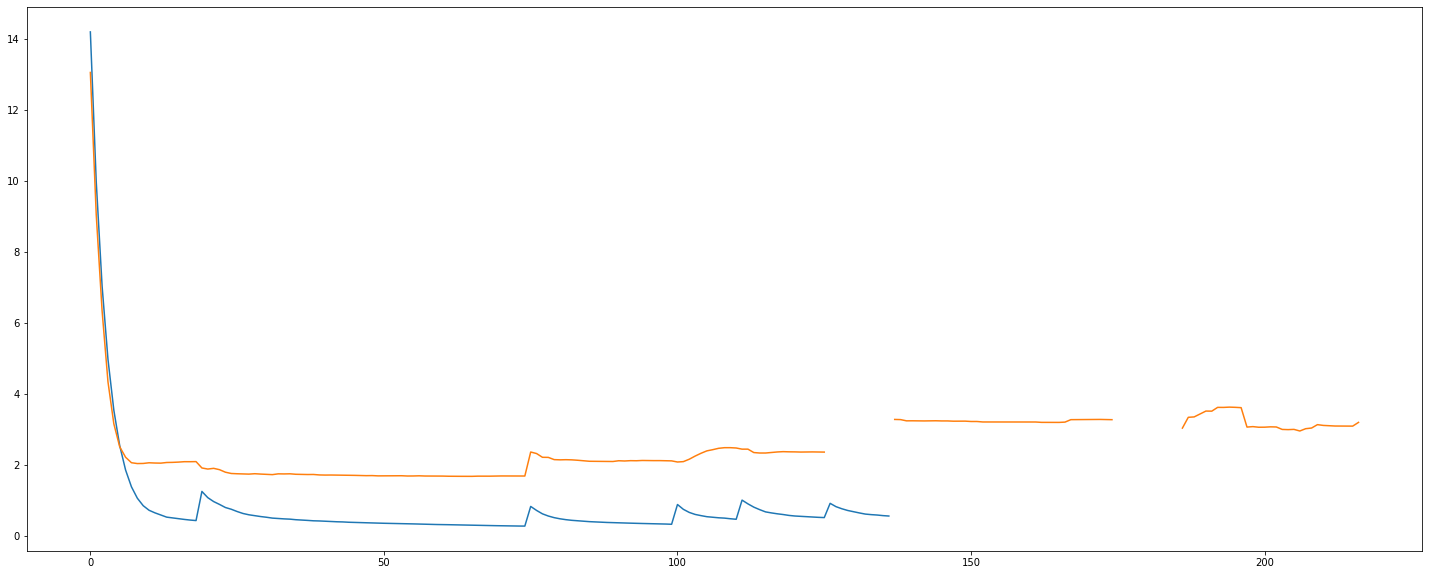

In [62]:
tscv = TimeSeriesSplit(TS_SPLIT)
model4 = xgb.XGBRegressor()
m = None
train_rmse = []
test_rmse = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = model4.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_test,  y_test)], verbose=False, xgb_model = m, early_stopping_rounds=EARLY_STOP)
    train_rmse += model4.evals_result()['validation_0']['rmse']
    test_rmse += model4.evals_result()['validation_1']['rmse']

plt.figure(figsize=(25,10))
plt.plot(train_rmse, label='train')
plt.plot(test_rmse, label='test')

In [63]:
predictions4 = model4.predict(X_test)
print(mean_squared_error(predictions4, y_test))

8.706828489490826


<AxesSubplot:xlabel='czas'>

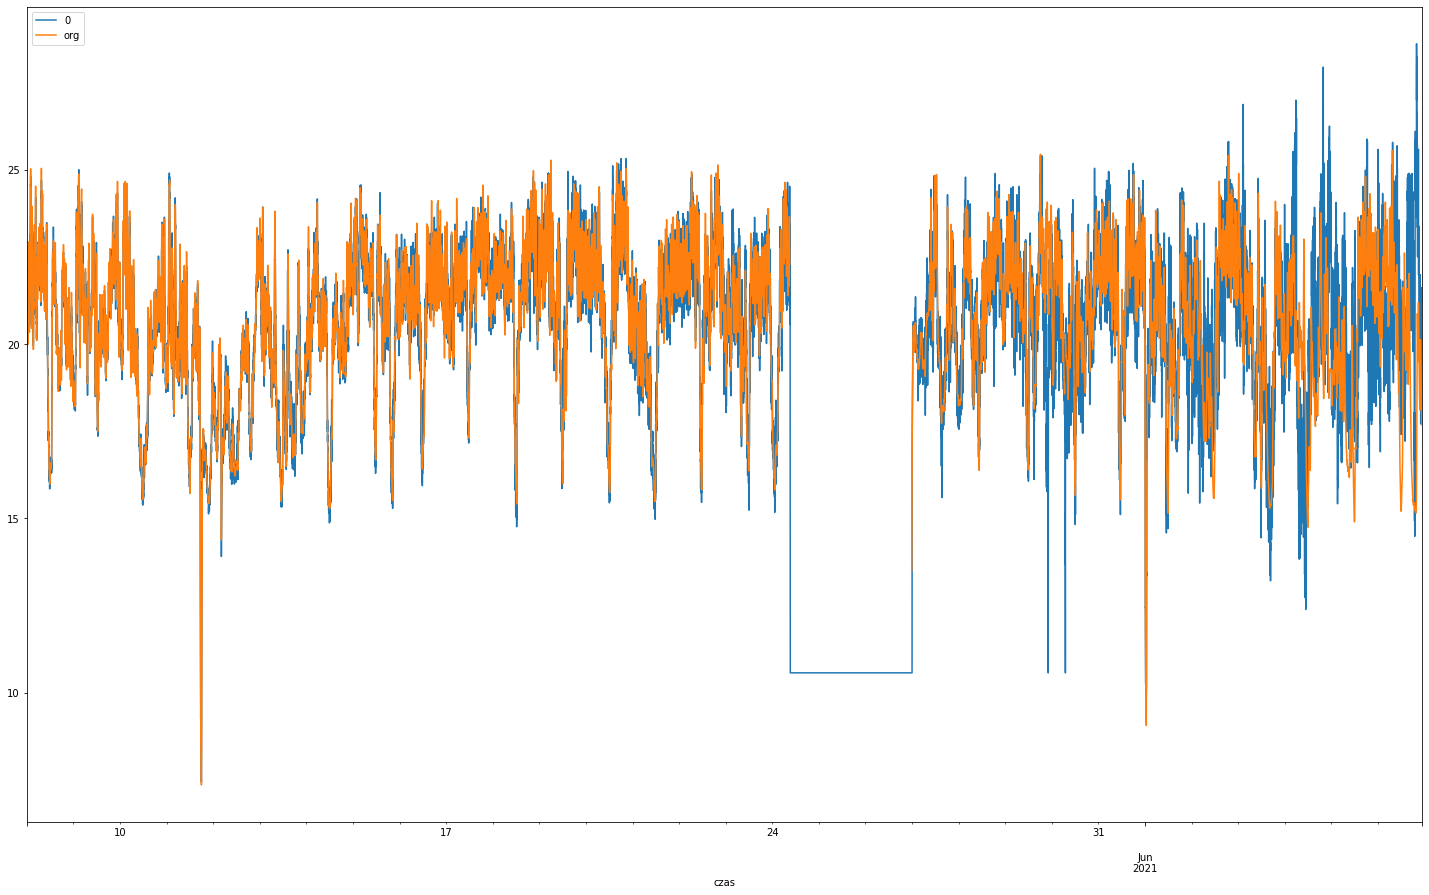

In [64]:
predictions4 = model4.predict(X)
d = pd.DataFrame(predictions4, index=y.index)
d['org'] = y
d.plot(figsize=(25,15))

In [65]:
X

,man_air_flow,man_co2,man_blow,man_dust,zak_mixer,zak_fry,zak_slag,zak_oxy1,zak_oxy2,zak_air,...,zak_sturoxy_4,zak_carbon_4,zak_sulfur_4,zak_over_seed_4,zak_under_seed_4,zak_slag_level_4,zcne_angle_4,zcne_loss_4,zcne_temp_4,zcne_shake_4
czas,,,,,,,,,,,,,,,,,,,,,
2021-05-08 00:00:00,2500.0,81.0,42.0,26.0,110.0,9.0,2.0,252.191348,30986.818132,9732.196647,...,307.0,8.86,10.59,3.48,60.500000,1370.0,14.348505,10.379728,1307.0,-0.120352
2021-05-08 00:01:00,2500.0,81.0,42.0,26.0,110.0,9.0,2.0,250.130182,30972.921550,9688.775000,...,307.0,8.86,10.59,3.48,60.500000,1370.0,14.408580,10.338273,1307.0,-0.295068
2021-05-08 00:02:00,2500.0,81.0,42.0,26.0,110.0,9.0,2.0,248.939719,30974.413965,9657.542057,...,307.0,8.86,10.59,3.48,60.500000,1370.0,13.830097,10.376101,1307.0,-0.054833
2021-05-08 00:03:00,2500.0,81.0,42.0,26.0,110.0,9.0,2.0,249.002518,30978.373244,9706.428499,...,307.0,8.86,10.59,3.48,60.500000,1370.0,13.801111,10.383205,1307.0,-0.191598
2021-05-08 00:04:00,2500.0,81.0,42.0,26.0,110.0,9.0,2.0,249.329449,30976.005143,9736.590446,...,307.0,8.86,10.59,3.48,60.500000,1370.0,13.956281,10.364934,1307.0,-0.271153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 22:30:00,2800.0,72.0,62.0,24.0,114.0,8.0,2.0,249.402662,27387.274089,15053.098080,...,276.0,8.81,10.18,3.32,59.400001,1180.0,12.886892,10.066061,1301.0,0.737020
2021-06-06 22:31:00,2800.0,72.0,62.0,24.0,114.0,8.0,2.0,245.658880,27406.593652,15006.063981,...,276.0,8.81,10.18,3.32,59.400002,1180.0,12.840119,10.071584,1301.0,0.658337
2021-06-06 22:32:00,2800.0,72.0,62.0,24.0,114.0,8.0,2.0,252.941990,27442.568815,14985.837403,...,276.0,8.81,10.18,3.32,59.400002,1180.0,12.838299,10.066816,1301.0,0.491585


In [74]:
# Prediction for point-in-time model

X = df_final.iloc[:,:-1]

SETTINGS_CHANGE_UNIT = [80.0, 0.8, 2.0, 0.5]  # how hard it is to adjust param
ADJUSTMENT_TARGET_WEIGHT = 0.05 # how important is adjustment cost against target difference

def find_winning_params(state, current_settings, target):
    params = np.ones((300,4))  # params configuration which we want to try
    params[:,0] = np.linspace(1900, 3500, 300)
    params[:,1] = np.linspace(65, 81, 300)
    params[:,2] = np.linspace(40, 70, 300)
    params[:,3] = np.linspace(13, 27, 300)

    aaa = np.ones((params.shape[0], state.shape[1])) * state.T
    aab = np.concatenate([params, aaa], axis=1)

    predictions = model1.predict(aab) # predict for all the params configurations

    target_diff = np.abs(predictions - target)
    adjustment_cost = np.sum(np.abs(aab[:,:4] - current_settings.reshape((1,4))) / SETTINGS_CHANGE_UNIT, axis=1)
    winner = np.argmin(target_diff + adjustment_cost * ADJUSTMENT_TARGET_WEIGHT)

    return params[winner,:]  # settings which we believe are the best to obtain target from current 

In [75]:
state = X.iloc[0,4:].values.reshape((-1, 1)) # real-time input from sensors
current_settings = X.iloc[0,:4].values

for t in range(15, 25):
    print(t, find_winning_params(state, current_settings, t))

15 [2691.97324415   72.91973244   54.84949833   19.92976589]
16 [2691.97324415   72.91973244   54.84949833   19.92976589]
17 [2670.56856187   72.70568562   54.44816054   19.74247492]
18 [3296.65551839   78.96655518   66.18729097   25.22073579]
19 [3339.46488294   79.39464883   66.98996656   25.59531773]
20 [2943.47826087   75.43478261   59.56521739   22.13043478]
21 [3018.39464883   76.18394649   60.96989967   22.78595318]
22 [3018.39464883   76.18394649   60.96989967   22.78595318]
23 [3018.39464883   76.18394649   60.96989967   22.78595318]
24 [3018.39464883   76.18394649   60.96989967   22.78595318]


In [93]:
import ipywidgets as widgets

int_range = widgets.FloatSlider(min=14, max=23, step=0.5,)
output2 = widgets.Output()
lab = widgets.Label(value='')
lab = widgets.HTMLMath(
    value=r"Use slider to see values",
)
display(int_range, lab)

def foo(t):
    rest=find_winning_params(state, current_settings, t)
    return rest

def on_value_change(change):
    val = change['new']
    parameters = foo(val)
    v1, v2, v3, v4 = map(lambda x : round(x,2), parameters)
    st= f"Przepływ powietrza: $${v1} [Nm^{3}/h]$$ \n Zawartość tlenu: $${v2} [\%]$$  Prędkość dmuchu $${v3} [M/s]$$ \n Nadawa pyłów procesowych $$ {v4} [Mg/h]$$"
    lab.value = st

int_range.observe(on_value_change, names='value')

FloatSlider(value=14.0, max=23.0, min=14.0, step=0.5)

HTMLMath(value='Use slider to see values')